In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm
import torch

In [90]:
from dataclasses import dataclass
import torch.nn as nn

@dataclass
class HarmonicSpheres:
    weights: list[int]
    spheres: torch.Tensor
    weights: torch.Tensor

    def __init__(self, npoints=100):
        phi = np.linspace(0, np.pi, npoints)
        theta = np.linspace(0, 2*np.pi, npoints)
        phi, theta = np.meshgrid(phi, theta)
        self.x = np.sin(phi) * np.cos(theta)
        self.y = np.sin(phi) * np.sin(theta)
        self.z = np.cos(phi)

        self.weights = torch.rand((3, 9))

        self.spheres = torch.empty((9, npoints, npoints))

        harmonic_cf = [[0, 0], [1, 1], [0, 1], [-1, 1], [2, 2], [1, 2], [0,2], [-1, 2], [-2, 2]]
        for i, [m, l] in enumerate(harmonic_cf):
            self.spheres[i, :, :] = torch.tensor(sph_harm(m, l, theta, phi).real)

    def get_total(self):
        weights = self.weights
        npoints = self.spheres.shape[1]

        res = torch.empty((npoints, npoints, 4))
        res[:, :, :3] = (weights @ self.spheres.reshape((9, npoints*npoints))).T.reshape(npoints, npoints, 3)
        resmin, resmax = res[:, :, :3].min(), res[:, :, :3].max()
        res[:, :, :3] = (res[:, :, :3] - resmin) / (resmax - resmin)
        return res

    def get_cartesian(self):
        return self.x, self.y, self.z

In [114]:
# input: point on the sphere (theta, phi)
# output: color (rgba)

import torch.nn as nn

class SphereNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(self.spheres.weights, requires_grad=True)
        self.spheres = HarmonicSpheres()
        self.npoints = self.spheres.spheres.shape[1]

    def forward(self):
        spheres = self.spheres.spheres
        res = torch.ones((self.npoints, self.npoints, 4))
        res[:, :, :3] = (self.weights @ spheres.view((9, self.npoints*self.npoints))).T.view(self.npoints, self.npoints, 3)
        # resmin, resmax = res[:, :, :3].min(), res[:, :, :3].max()
        # res[:, :, :3] = (res[:, :, :3] - resmin) / (resmax - resmin)
        return res

In [116]:
import torch.optim as optim

spheres = HarmonicSpheres(100)

target = spheres.get_total()

model = SphereNet()

loss_fn = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr=0.03)
epochs = 100

for epoch in range(epochs):
    optim.zero_grad()

    out = model()
    loss = loss_fn(out, target)

    loss.backward()
    optim.step()

    print(loss.item())


TypeError: HarmonicSpheres.get_total() missing 1 required positional argument: 'weights'

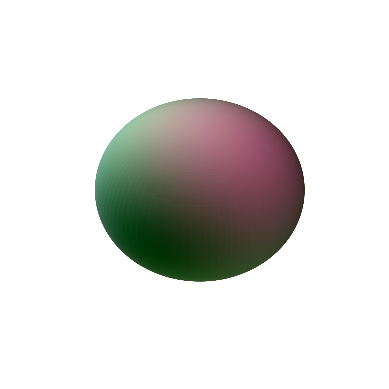

In [49]:
spheres = HarmonicSpheres(100)

rcolors = spheres.get_total()
x,y,z = spheres.get_cartesian()

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=rcolors)
# Turn off the axis planes
ax.set_axis_off()
plt.show()